First 5 rows of normalized attributes:
    5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  Bald  \
0                 0                1           1                0     0   
1                 0                0           0                1     0   
2                 0                0           0                0     0   
3                 0                0           1                0     0   
4                 0                1           1                0     0   

   Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  Sideburns  Smiling  \
0      0         0         0           0           0  ...          0        1   
1      0         0         1           0           0  ...          0        1   
2      0         1         0           0           0  ...          0        0   
3      0         0         0           0           0  ...          0        0   
4      0         1         0           0           0  ...          0        0   

   Straight_Hair  Wavy

/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10
Total Batches in this Epoch: 250
Batch 10/250, Loss: 0.6613
Batch 20/250, Loss: 0.6166
Batch 30/250, Loss: 0.5736
Batch 40/250, Loss: 0.5525
Batch 50/250, Loss: 0.5110
Batch 60/250, Loss: 0.5112
Batch 70/250, Loss: 0.4714
Batch 80/250, Loss: 0.4448
Batch 90/250, Loss: 0.4566
Batch 100/250, Loss: 0.4464
Batch 110/250, Loss: 0.4062
Batch 120/250, Loss: 0.3836
Batch 130/250, Loss: 0.4262
Batch 140/250, Loss: 0.4109
Batch 150/250, Loss: 0.3976
Batch 160/250, Loss: 0.4342
Batch 170/250, Loss: 0.4288
Batch 180/250, Loss: 0.3670
Batch 190/250, Loss: 0.3561
Batch 200/250, Loss: 0.3586
Batch 210/250, Loss: 0.3654
Batch 220/250, Loss: 0.3689
Batch 230/250, Loss: 0.4128
Batch 240/250, Loss: 0.3657
Batch 250/250, Loss: 0.3804
Epoch 1, Train Loss: 0.4462, Test Loss: 0.3319, Accuracy: 86.02%

Epoch 2/10
Total Batches in this Epoch: 250
Batch 10/250, Loss: 0.3893
Batch 20/250, Loss: 0.4155
Batch 30/250, Loss: 0.3310
Batch 40/250, Loss: 0.3390
Batch 50/250, Loss: 0.3461
Batch 60/250, Loss:

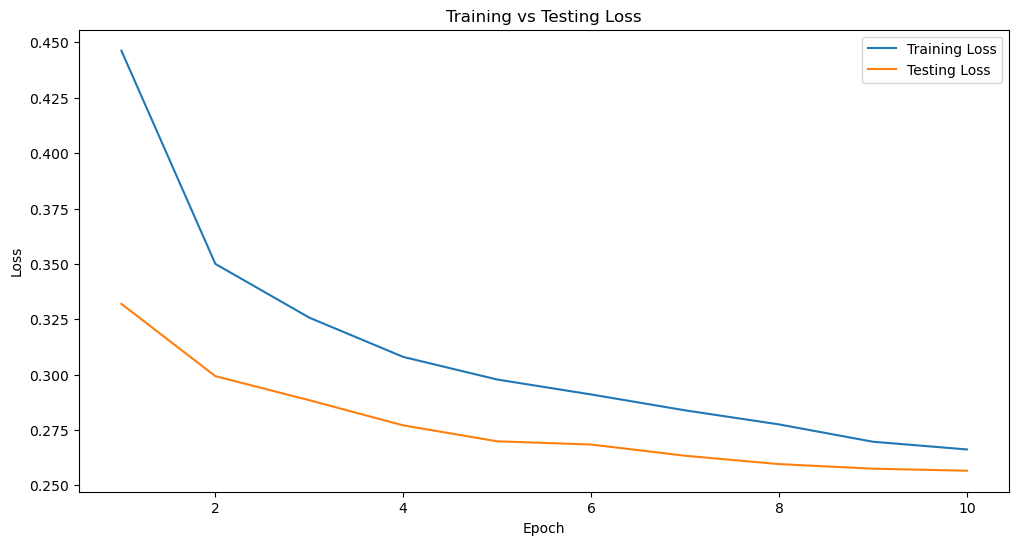

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/pytorch/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/pytorch/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_pickle.UnpicklingError: pickle data was truncated


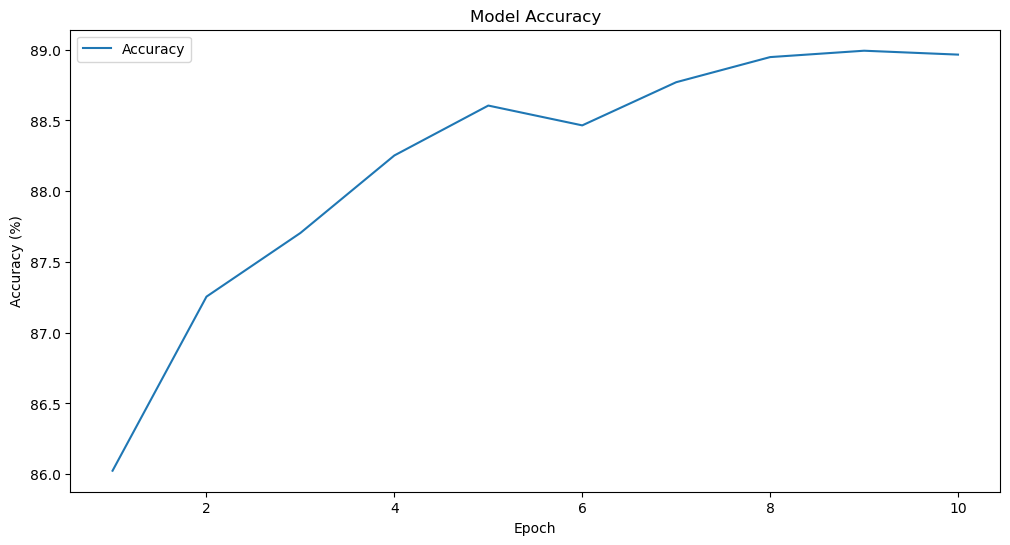

Model saved to celeba_resnet18_finetuned.pth


In [12]:
import os
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms, models
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from celeba_dataset import CelebADataset

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# File paths
base_dir = os.getcwd()
img_dir = os.path.join(base_dir, "img_align_celeba", "img_align_celeba")
attr_file = os.path.join(base_dir, "list_attr_celeba.csv")
bbox_file = os.path.join(base_dir, "list_bbox_celeba.csv")
partition_file = os.path.join(base_dir, "list_eval_partition.csv")
landmark_file = os.path.join(base_dir, "list_landmarks_align_celeba.csv")

# Data transformations with improved augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset and DataLoader setup
dataset = CelebADataset(img_dir, attr_file, bbox_file, partition_file, landmark_file, split="train", transform=transform)
subset_size = 5000
indices = list(range(subset_size))
small_dataset = Subset(dataset, indices)
train_size = int(0.8 * len(small_dataset))
test_size = len(small_dataset) - train_size
train_dataset, test_dataset = random_split(small_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Model definition with ResNet18 backbone
class CelebACNN(nn.Module):
    def __init__(self, num_attributes):
        super(CelebACNN, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, num_attributes)
            # Removed nn.Sigmoid()
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc_layers(x)
        return x  # Raw logits

# Model initialization
num_attributes = 40
model = CelebACNN(num_attributes).to(device)

# Unfreeze backbone for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Loss, optimizer, and scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

# Training function with batch progress monitoring
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    total_batches = len(dataloader)
    print(f"Total Batches in this Epoch: {total_batches}")

    for batch_idx, (images, attributes, _, _) in enumerate(dataloader):
        images, attributes = images.to(device), attributes.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        # Loss computation and backward pass
        loss = criterion(outputs, attributes)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0 or batch_idx + 1 == total_batches:
            print(f"Batch {batch_idx+1}/{total_batches}, Loss: {loss.item():.4f}")

    return running_loss / len(dataloader)

# Evaluation function with improved accuracy calculation
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, attributes, _, _ in dataloader:
            images, attributes = images.to(device), attributes.to(device)
            outputs = model(images)
            loss = criterion(outputs, attributes)
            running_loss += loss.item()

            # Apply sigmoid to outputs
            outputs = torch.sigmoid(outputs)
            # Predictions and accuracy calculation
            predictions = (outputs > 0.5).int()
            total_correct += (predictions == attributes).sum().item()
            total_samples += attributes.numel()

    accuracy = total_correct / total_samples * 100
    return running_loss / len(dataloader), accuracy

# Training loop
num_epochs = 10  # Increased epochs for better training
train_losses = []
test_losses = []
accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, accuracy = evaluate(model, test_loader, criterion, device)
    scheduler.step()
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Plot training vs testing loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Save the trained model
model_save_path = "celeba_resnet18_finetuned.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


In [14]:
# Save the trained model
model_path = "celeba_cnn_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to celeba_cnn_model.pth


In [42]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# celebA attribute list 
attributes_list = [
    "5_o_Clock_Shadow", "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", "Bald",
    "Bangs", "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", "Blurry", "Brown_Hair",
    "Bushy_Eyebrows", "Chubby", "Double_Chin", "Eyeglasses", "Goatee", "Gray_Hair",
    "Heavy_Makeup", "High_Cheekbones", "Male", "Mouth_Slightly_Open", "Mustache",
    "Narrow_Eyes", "No_Beard", "Oval_Face", "Pale_Skin", "Pointy_Nose", "Receding_Hairline",
    "Rosy_Cheeks", "Sideburns", "Smiling", "Straight_Hair", "Wavy_Hair", "Wearing_Earrings",
    "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace", "Wearing_Necktie", "Young"
]

class CelebACNN(torch.nn.Module): 
    def __init__(self, num_attributes):
        super(CelebACNN, self).__init__()
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(128 * 16 * 16, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, num_attributes),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model = CelebACNN(num_attributes=40)  #Loading the model

#loading the weights calculated from the saved model before
loaded_model.load_state_dict(torch.load("celeba_cnn_model.pth", map_location=device))  
loaded_model.to(device)
loaded_model.eval()
print("Model loaded and ready for predictions.")

image_path = "/Users/dionbaldsing/Documents/CMU/AI for med/project Fahad/archive/testimage/diontest.jpg"

input_image = Image.open(image_path)
input_image.show()  # Display the image

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
preprocessed_image = transform(input_image).unsqueeze(0).to(device)

# Make predictions
with torch.no_grad():
    output = loaded_model(preprocessed_image)  # Forward pass
predicted_attributes = (output.squeeze() > 0.5).int()  # Threshold probabilities at 0.5

# Display predicted attributes
print("\nPredicted Attributes:")
for i, attr in enumerate(attributes_list):
    print(f"{attr}: {'Yes' if predicted_attributes[i] == 1 else 'No'}")


Model loaded and ready for predictions.

Predicted Attributes:
5_o_Clock_Shadow: No
Arched_Eyebrows: No
Attractive: No
Bags_Under_Eyes: No
Bald: No
Bangs: No
Big_Lips: No
Big_Nose: No
Black_Hair: No
Blond_Hair: No
Blurry: No
Brown_Hair: No
Bushy_Eyebrows: No
Chubby: No
Double_Chin: No
Eyeglasses: No
Goatee: No
Gray_Hair: No
Heavy_Makeup: No
High_Cheekbones: No
Male: Yes
Mouth_Slightly_Open: Yes
Mustache: No
Narrow_Eyes: No
No_Beard: Yes
Oval_Face: No
Pale_Skin: No
Pointy_Nose: No
Receding_Hairline: No
Rosy_Cheeks: No
Sideburns: No
Smiling: No
Straight_Hair: No
Wavy_Hair: No
Wearing_Earrings: No
Wearing_Hat: No
Wearing_Lipstick: No
Wearing_Necklace: No
Wearing_Necktie: No
Young: No
